# Imports

In [11]:
import os
import glob
import pandas as pd
import shutil
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import torch
#from utils.utils import plot_results

In [4]:
images_dir = './raw/images'
train_dir = './dataset/train/images'
val_dir = './dataset/val/images'
test_dir = './dataset/test/images'
test_df = pd.read_csv('./raw/test.csv')

# Detection

In [11]:
#!python yolov5/detect.py --weights yolov5/runs/train/exp2/weights/best.pt --img 640 --conf 0.4 --source dataset/test/images

In [175]:
#os.mkdir('outputs')

weight_path = 'yolov5/runs/train/exp2/weights/best.pt'
model = torch.hub.load('yolov5', 'custom', path=weight_path, source='local')
final_output = pd.DataFrame()

#model.conf = 0.6

for image in test_df.image_path.unique():
    image_path = os.path.join(test_dir,image)
    results = model(image_path)
    output = results.pandas().xyxy[0]
    output['image_path'] = image
    final_output = pd.concat([final_output, output])

final_output.to_csv('./outputs/results_conf_shuffil.csv', index=False, encoding='utf-8-sig')

YOLOv5 🚀 v7.0-71-gc442a2e Python-3.8.10 torch-1.13.1+cu117 CUDA:0 (NVIDIA A100-SXM4-40GB, 40396MiB)

Fusing layers... 
Model summary: 322 layers, 86240704 parameters, 0 gradients, 204.0 GFLOPs
Adding AutoShape... 


# Detect with low conf

In [82]:
print('Results pics:', str(final_output.image_path.nunique()), final_output.shape )
print('Testset pics:', str(test_df.image_path.nunique()) )

Results pics: 1240 (2049, 8)
Testset pics: 2092


In [83]:
def tesl_low_conf(test_df, last_df, model, conf, keep ):
    not_predict_pics = test_df[~test_df.image_path.isin(last_df.image_path.unique())]
    val_output = pd.DataFrame()
    
    model.conf = conf
    
    for image in not_predict_pics.image_path.unique():
        results = model(os.path.join(test_dir,image))
        output = results.pandas().xyxy[0]
        output['image_path'] = image
        val_output = pd.concat([val_output, output])
    
    output = pd.DataFrame()
    for image in val_output.image_path.unique():
        selected = val_output[val_output.image_path == image].sort_values(by='confidence', ascending=False).head(keep)
        output = pd.concat([output, selected])
    
    output = pd.concat([output, last_df])
    print('output shape:' , output.shape)
    print('output images:' , output.image_path.nunique())
    
    return output
    

In [84]:
final_output.describe()

,xmin,ymin,xmax,ymax,confidence
count,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000
mean,399.927335,193.797296,579.665341,303.785114,0.711513
std,263.689271,84.527592,261.232117,92.640690,0.064081
min,0.000000,0.000000,64.357201,37.545410,0.600156
25%,162.427490,139.271988,361.355530,240.924408,0.658699
50%,415.870331,185.908127,595.671021,292.207397,0.708998
75%,621.138611,239.855850,802.630249,355.327881,0.762642
max,897.940247,467.815521,960.000000,540.000000,0.885038


In [127]:
df_10 = tesl_low_conf(test_df, final_output, model, 0.1, 30) 

output shape: (4135, 8)
output images: 1961


In [128]:
df_4 = tesl_low_conf(test_df, df_10, model, 0.04, 15)

output shape: (4235, 8)
output images: 2029


In [129]:
val_output = tesl_low_conf(test_df, df_4, model, 0.001, 5)

output shape: (4550, 8)
output images: 2092


In [209]:
val_output.xmax = val_output.xmax.astype(int) - 3
val_output.xmin = val_output.xmin.astype(int)  + 3
val_output_back.ymax = val_output.ymax.astype(int) - 2
val_output.ymin = val_output.ymin.astype(int) + 2





val_output.to_csv('./outputs/val_final_conf_shuffle.csv', index=False, encoding='utf-8-sig')
val_output = val_output_back_up[['class','image_path','name','xmax','xmin','ymax','ymin']]
val_output.to_csv('./outputs/final_results_shuffle.csv', index=False, encoding='utf-8-sig')

In [194]:
#############################
val_output = tesl_low_conf(test_df, final_output, model, 0.001,1)
###########################3



output shape: (5072, 8)
output images: 2092


In [5]:
def object_detection(df, path=test_dir, change_width=False, image_path=False):
    
    if image_path != False:
        select_df = df[df.image_path == image_path].reset_index()
    else:
        df = df.sample(frac=1)
        image_path = df.iloc[0].image_path
        select_df = df[df.image_path == image_path].reset_index()
        
    print(image_path)
    image = cv2.cvtColor(cv2.imread(os.path.join(path, image_path)), cv2.COLOR_BGR2RGB)
    for i in select_df.index:
        xmin = select_df.iloc[i].xmin #* 2
        ymin = select_df.iloc[i].ymin #* 2
        xmax = select_df.iloc[i].xmax #* 2
        ymax = select_df.iloc[i].ymax #* 2
        label = select_df.iloc[i]['name']
        
        height = image.shape[0]
        width = image.shape[1]
        if change_width == True:
            width = 960
            image = cv2.resize(image, (width, height), interpolation = cv2.INTER_AREA)
            xmax = xmax / 2
            xmin = xmin / 2

        print('class:' , select_df.iloc[i]['name'])
        print('xmin:' , xmin)
        print('ymin:' , ymin)
        print('xmax:' , xmax)
        print('ymax:' , ymax)
        print('----------------------------')
            
        cv2.rectangle(image,
                      (int(xmin) , int(ymin) ),
                      (int(xmax) , int(ymax) ),
                      (0,255,0), thickness=2)

        ((label_width, label_height), _) = cv2.getTextSize(label, fontFace=cv2.FONT_HERSHEY_PLAIN, 
        fontScale=1.75, thickness=2)

        cv2.rectangle(
      image,
      (int(xmin) , int(ymin)),
      (int(xmin + label_width + label_width * 0.05), int(ymin + label_height + label_height * 0.25)),
      color=(255, 0, 0),
      thickness=cv2.FILLED
    )

        cv2.putText(
      image,
      label,
      org=(int(xmin), int(ymin + label_height + label_height * 0.25)), 
      fontFace=cv2.FONT_HERSHEY_PLAIN,
      fontScale=1.75,
      color=(255, 255, 255),
      thickness=2 )

    plt.imshow(image)
    plt.show()

            


e54e4848355d39ab1dce55b47edcc33a.jpg
class: POTHOLES
xmin: 512
ymin: 216
xmax: 615
ymax: 303
----------------------------
class: POTHOLES
xmin: 568
ymin: 247
xmax: 705
ymax: 354
----------------------------
class: POTHOLES
xmin: 655
ymin: 305
xmax: 899
ymax: 476
----------------------------
class: POTHOLES
xmin: 823
ymin: 396
xmax: 957
ymax: 538
----------------------------


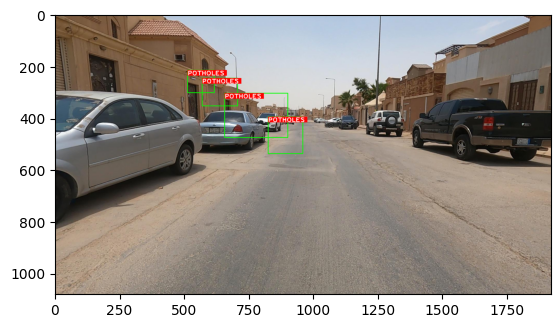

In [12]:
df = pd.read_csv('outputs/final_results_shuffle.csv') 
object_detection(df=df[df.image_path=='e54e4848355d39ab1dce55b47edcc33a.jpg'], path=test_dir, change_width=False, image_path=False)